In [1]:
import glob, os, json, re, unicodedata
from bs4 import BeautifulSoup

load_verbose = 0
input_text = []
input_labels = []
labels = {"Barack Obama": 0,
          "Donald J. Trump": 1,
          "Dwight D. Eisenhower": 2,
          "Franklin D. Roosevelt": 3,
          "George Bush": 4,
          "George W. Bush": 5,
          "Gerald R. Ford": 6,
          "Harry S. Truman": 7,
          "Herbert Hoover": 8,
          "Jimmy Carter": 9,
          "John F. Kennedy": 10,
          "Lyndon B. Johnson": 11,
          "Richard Nixon": 12,
          "Ronald Reagan": 13,
          "William J. Clinton": 14}

# load raw text files straight in, no parsing
directory = "../data/processed/"
file_to_label = {"Obama": "Barack Obama", "Trump": "Donald J. Trump"}
for filename in glob.glob(os.path.join(directory, '*.txt')):
    arr = filename.replace(directory,'').split("_")
    input_labels = input_labels + [labels[file_to_label[arr[0]]]]
    raw = open(filename).read().decode("UTF-8").encode("ascii","ignore")
    input_text = input_text + [raw] 
        
# load JSON text files; parsing into raw text
directory = "../data/unprocessed/"
for filename in glob.glob(os.path.join(directory, '*.json')):
        json_data=open(filename)
        data = json.load(json_data)
        json_data.close()
        for data2 in data["speeches"]:
            if ('News Conference With' not in data2['name']):
                # data2['text'] has a lot of htmtl tags in there. We still need to parse it            
                raw = BeautifulSoup(data2['text'], "html.parser").get_text()
                raw = unicodedata.normalize('NFKD', raw).encode('ascii','ignore')
                # Remove []
                raw = re.sub(' \[.*?\]',' ', raw, flags=re.DOTALL)
                # Remove ()
                raw = re.sub(' \(.*?\)',' ', raw, flags=re.DOTALL)
                # Removing the questions
                raw = re.sub('[A-Z,\s,\.]Q\..*? The President\.','\.',raw, flags=re.DOTALL)
                raw = re.sub('^[A-Z,\s]*THE PRESIDENT\.','',raw, flags=re.DOTALL)
                raw = re.sub('[A-Z,\s,\.]Q\..*?THE PRESIDENT\.','\.',raw, flags=re.DOTALL)
                
                # capture speaker (i.e., label)
                speaker = data2['speaker']
                
                # push speaker and text
                if (load_verbose == 1):
                    print "Loading: ", data2['speaker'], "(", labels[speaker], "), ", data2['name']
                input_labels = input_labels + [labels[speaker]] 
                input_text = input_text + [raw]
                
print "Loaded", len(input_text), "speeches for", len(set(input_labels)), "presidents."

Loaded  1751 speeches for 15 presidents.


In [2]:
from sklearn.cross_validation import train_test_split
from keras.preprocessing.text import Tokenizer
from keras.preprocessing import sequence
from keras.utils import to_categorical

max_len = 2000

tokenizer = Tokenizer(num_words=1000, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n',
               lower=True, split=" ", char_level=False)
tokenizer.fit_on_texts(input_text)
tk_test = tokenizer.texts_to_sequences(input_text)

X = sequence.pad_sequences(tk_test, maxlen=max_len)
y = to_categorical(input_labels)

train_X, test_X, train_y, test_y = train_test_split(X, y, train_size=0.8, random_state=0)

print "Prepared training (", len(train_X), "records) and test (", len(test_X), "records) data sets."

//anaconda/envs/keras_tf/lib/python2.7/site-packages/sklearn/cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)
Using TensorFlow backend.


Prepared training ( 1400 records) and test ( 351 records) data sets.


In [3]:
from keras.models import Sequential
from keras.layers import Dense, Activation, Embedding, SimpleRNN, Dropout

max_features = 20000

model = Sequential()
print('Build model...')
model = Sequential()
model.add(Embedding(max_features, 100, input_length=max_len))
model.add(Dropout(0.2))
model.add(SimpleRNN(100))
model.add(Dense(15))
model.add(Activation('softmax'))
model.compile(loss='categorical_crossentropy', optimizer='Adagrad',metrics=['categorical_accuracy'])
print(model.summary())

model.fit(train_X, y=train_y, batch_size=50, nb_epoch=10, verbose=1)

Build model...
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      (None, 2000, 100)         2000000   
_________________________________________________________________
dropout_1 (Dropout)          (None, 2000, 100)         0         
_________________________________________________________________
simple_rnn_1 (SimpleRNN)     (None, 100)               20100     
_________________________________________________________________
dense_1 (Dense)              (None, 15)                1515      
_________________________________________________________________
activation_1 (Activation)    (None, 15)                0         
Total params: 2,021,615
Trainable params: 2,021,615
Non-trainable params: 0
_________________________________________________________________
None


//anaconda/envs/keras_tf/lib/python2.7/site-packages/keras/models.py:844: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  warnings.warn('The `nb_epoch` argument in `fit` '


Epoch 1/10
1400/1400 [==============================] - 24s - loss: 2.8023 - categorical_accuracy: 0.0921    
Epoch 2/10
1400/1400 [==============================] - 24s - loss: 2.5410 - categorical_accuracy: 0.1371    
Epoch 3/10
1400/1400 [==============================] - 24s - loss: 2.4903 - categorical_accuracy: 0.1550    
Epoch 4/10
1400/1400 [==============================] - 24s - loss: 2.4769 - categorical_accuracy: 0.1471    
Epoch 5/10
1400/1400 [==============================] - 24s - loss: 2.4505 - categorical_accuracy: 0.1607    
Epoch 6/10
1400/1400 [==============================] - 24s - loss: 2.4406 - categorical_accuracy: 0.1700    
Epoch 7/10
1400/1400 [==============================] - 24s - loss: 2.4421 - categorical_accuracy: 0.1536    
Epoch 8/10
1400/1400 [==============================] - 24s - loss: 2.4501 - categorical_accuracy: 0.1586    
Epoch 9/10
1400/1400 [==============================] - 24s - loss: 2.4520 - categorical_accuracy: 0.1586    
Epoch 10/1

In [4]:
import numpy as np

# Evaluate performance
print "Evaluating test data..."
loss_and_metrics = model.evaluate(test_X, test_y)

# Make some predictions
print "\nPredicting using test data..."
pred_y = model.predict(test_X, batch_size=100)
pred_y_collapsed = np.argmax(pred_y, axis=1)
test_y_collapsed = np.argmax(test_y, axis=1)

#print pred_y_collapsed, test_y_collapsed

print model.metrics_names
print loss_and_metrics

Evaluating test data...
351/351 [==============================] - 1s     

Predicting using test data...
['loss', 'categorical_accuracy']
[2.4366748237881564, 0.18803418727002591]


Confusion matrix, without normalization
[[ 2  0  0  2  0  0  0 22  8  0  0  0  0  0  0]
 [ 0  0  1  2  0  0  0  2  0  0  0  1  0  0  0]
 [ 0  0  0  0  0  0  0 27  8  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 32  9  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 10  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 50 16  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 42 14  0  0  0  0  0  0]
 [ 0  0  1  0  0  0  0 16  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 11  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0 20  3  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  4  1  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  8  2  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  5  3  0  0  0  0  0  0]]
Normalized confusion matrix
[[ 0.06  0.    0.    0.06  0.    0.    0.    0.65  0.24  0.    0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.17  0.33  0.    0.    0.    0.33  0.    0.    0.    0.17
   0.    0.    0.  ]
 [ 0.    0.    0.    0.

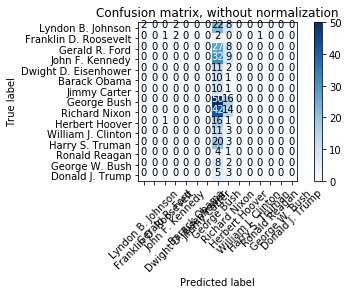

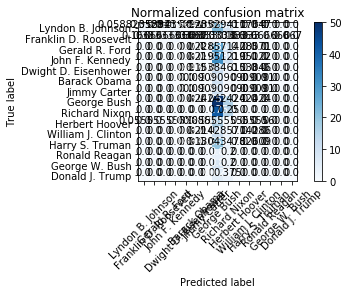

In [5]:
# from scikit-learn examples @
# http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html 
%matplotlib inline
import itertools
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

# Compute confusion matrix
cnf_matrix = confusion_matrix(test_y_collapsed, pred_y_collapsed)
np.set_printoptions(precision=2)

# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels.keys(),
                      title='Confusion matrix, without normalization')

# Plot normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=labels.keys(), normalize=True,
                      title='Normalized confusion matrix')

plt.show()